<a href="https://colab.research.google.com/github/faontane-git/fashion-transfer-learning/blob/main/Proyecto_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto FashionMNIST: estudio comparativo de tres modelos de transferencia

## 1. Setup

In [2]:
!pip install torch torchvision matplotlib seaborn -q
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from pathlib import Path
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo seleccionado: {device}")


✅ Dispositivo seleccionado: cuda


## 2. Datos

In [4]:
DATA_DIR = './data'
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#Transformación básica para FashionMNIST (normalización simple para una sola canal)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # para imágenes escala de grises
])

#Cargar datasets
trainval_dataset = datasets.FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transform)

#Particionar en 80% train y 20% val
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = trainval_dataset.classes
print(f"✅ Clases: {class_names}")
print(f"✅ Tamaños: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")


✅ Clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
✅ Tamaños: train=48000, val=12000, test=10000


## 3. Preprocesamiento

Dimensión de lote: torch.Size([64, 1, 28, 28])
Etiquetas: ['Bag', 'Shirt', 'Trouser', 'Sneaker', 'Bag', 'Trouser']


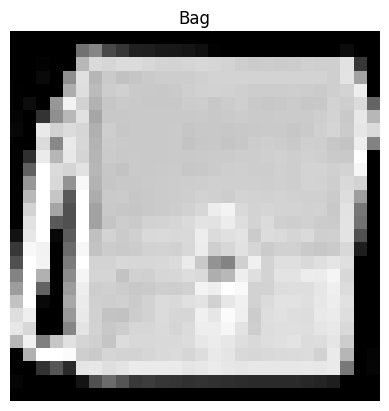

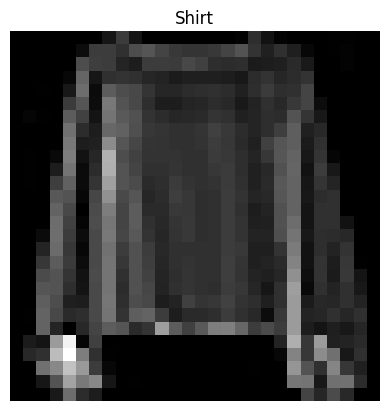

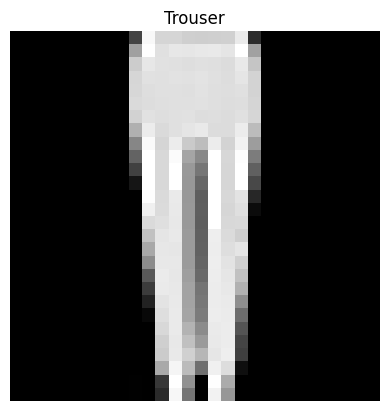

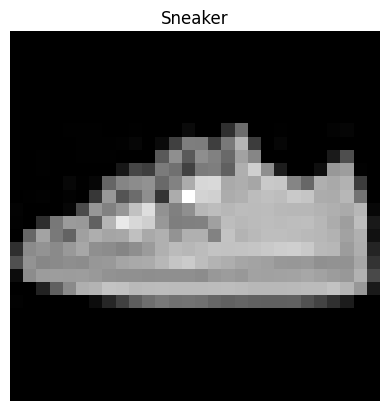

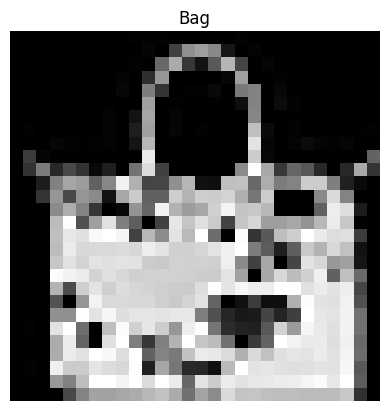

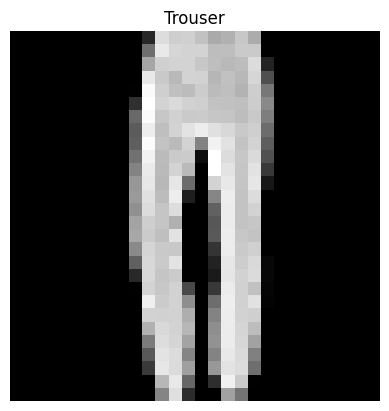

In [5]:
import matplotlib.pyplot as plt

def imshow(img, label=None):
    img = img * 0.5 + 0.5
    npimg = img.numpy().squeeze()
    plt.imshow(npimg, cmap="gray")
    if label is not None:
        plt.title(label)
    plt.axis("off")
    plt.show()

examples = next(iter(train_loader))
images, labels = examples

print(f"Dimensión de lote: {images.shape}")
print("Etiquetas:", [class_names[label] for label in labels[:6]])

for i in range(6):
    imshow(images[i], label=class_names[labels[i]])


## 4. Entrenamiento A/B/C

In [8]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path

RESULTS_DIR = Path("/content/results")
RESULTS_DIR.mkdir(exist_ok=True)

def build_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def build_mobilenet_v2(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def build_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct += (output.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion=None):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            if criterion:
                total_loss += criterion(output, y).item() * X.size(0)
            preds = output.argmax(1)
            correct += (preds == y).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = correct / len(dataloader.dataset)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return {
        "acc": acc,
        "f1_macro": f1,
        "cm": cm,
        "loss": total_loss / len(dataloader.dataset) if criterion else None
    }

MODELS = {
    "ResNet18": build_resnet18,
    "MobileNetV2": build_mobilenet_v2,
    "EfficientNetB0": build_efficientnet_b0,
}

EPOCHS = 10
LR = 1e-3
history = []

for name, builder in MODELS.items():
    print(f"\n=== Entrenando {name} ===")
    model = builder(len(class_names)).to(device)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.parameters():
        if param.ndim == 2 or param.ndim == 1:
            param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_metrics = evaluate(model, val_loader, criterion)
        print(f"[{epoch:02d}] Train: loss={tr_loss:.4f} acc={tr_acc:.4f} | Val: acc={val_metrics['acc']:.4f} f1={val_metrics['f1_macro']:.4f}")
        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    model.load_state_dict(best_state)
    test_metrics = evaluate(model, test_loader)

    torch.save(model.state_dict(), RESULTS_DIR / f"{name}_best.pth")

    history.append({
        "modelo": name,
        "val_acc_best": float(best_val_acc),
        "test_acc": float(test_metrics["acc"]),
        "test_f1_macro": float(test_metrics["f1_macro"]),
        "cm": test_metrics["cm"]
    })

df = pd.DataFrame(history)
df.to_csv(RESULTS_DIR / "tabla_comparativa.csv", index=False)
df



=== Entrenando ResNet18 ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


[01] Train: loss=0.7821 acc=0.7172 | Val: acc=0.7884 f1=0.7892
[02] Train: loss=0.5358 acc=0.8031 | Val: acc=0.8111 f1=0.8107
[03] Train: loss=0.4802 acc=0.8237 | Val: acc=0.8283 f1=0.8246
[04] Train: loss=0.4483 acc=0.8364 | Val: acc=0.8419 f1=0.8419
[05] Train: loss=0.4245 acc=0.8431 | Val: acc=0.8441 f1=0.8447
[06] Train: loss=0.4036 acc=0.8500 | Val: acc=0.8485 f1=0.8493
[07] Train: loss=0.3910 acc=0.8564 | Val: acc=0.8533 f1=0.8551
[08] Train: loss=0.3815 acc=0.8585 | Val: acc=0.8406 f1=0.8385
[09] Train: loss=0.3657 acc=0.8645 | Val: acc=0.8525 f1=0.8538
[10] Train: loss=0.3635 acc=0.8639 | Val: acc=0.8594 f1=0.8604


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Entrenando MobileNetV2 ===
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


[01] Train: loss=0.7387 acc=0.7296 | Val: acc=0.8157 f1=0.8141
[02] Train: loss=0.4884 acc=0.8236 | Val: acc=0.8342 f1=0.8339
[03] Train: loss=0.4228 acc=0.8475 | Val: acc=0.8574 f1=0.8570
[04] Train: loss=0.3863 acc=0.8582 | Val: acc=0.8688 f1=0.8694
[05] Train: loss=0.3701 acc=0.8653 | Val: acc=0.8725 f1=0.8717
[06] Train: loss=0.3429 acc=0.8746 | Val: acc=0.8644 f1=0.8661
[07] Train: loss=0.3322 acc=0.8786 | Val: acc=0.8762 f1=0.8771
[08] Train: loss=0.3179 acc=0.8840 | Val: acc=0.8762 f1=0.8769
[09] Train: loss=0.3091 acc=0.8863 | Val: acc=0.8824 f1=0.8829
[10] Train: loss=0.3050 acc=0.8894 | Val: acc=0.8881 f1=0.8891


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Entrenando EfficientNetB0 ===
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 72.9MB/s]


[01] Train: loss=1.1470 acc=0.5915 | Val: acc=0.6916 f1=0.6918
[02] Train: loss=0.8413 acc=0.6903 | Val: acc=0.7348 f1=0.7327
[03] Train: loss=0.7450 acc=0.7239 | Val: acc=0.7686 f1=0.7673
[04] Train: loss=0.6760 acc=0.7494 | Val: acc=0.7857 f1=0.7852
[05] Train: loss=0.6240 acc=0.7683 | Val: acc=0.7977 f1=0.7959
[06] Train: loss=0.5861 acc=0.7833 | Val: acc=0.8045 f1=0.8040
[07] Train: loss=0.5601 acc=0.7932 | Val: acc=0.8156 f1=0.8126
[08] Train: loss=0.5314 acc=0.8033 | Val: acc=0.8233 f1=0.8245
[09] Train: loss=0.5084 acc=0.8132 | Val: acc=0.8337 f1=0.8340
[10] Train: loss=0.4858 acc=0.8212 | Val: acc=0.8449 f1=0.8447


,modelo,val_acc_best,test_acc,test_f1_macro,cm
0,ResNet18,0.859417,0.8562,0.856055,"[[765, 5, 14, 51, 14, 1, 142, 0, 8, 0], [0, 97..."
1,MobileNetV2,0.888083,0.8812,0.881795,"[[771, 1, 21, 30, 5, 1, 163, 0, 8, 0], [2, 968..."
2,EfficientNetB0,0.844917,0.8408,0.840139,"[[805, 5, 21, 40, 7, 1, 111, 0, 10, 0], [3, 94..."


## 5. Evaluación

/tmp/ipython-input-1036020537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="modelo", y="test_acc", palette="Blues_d")


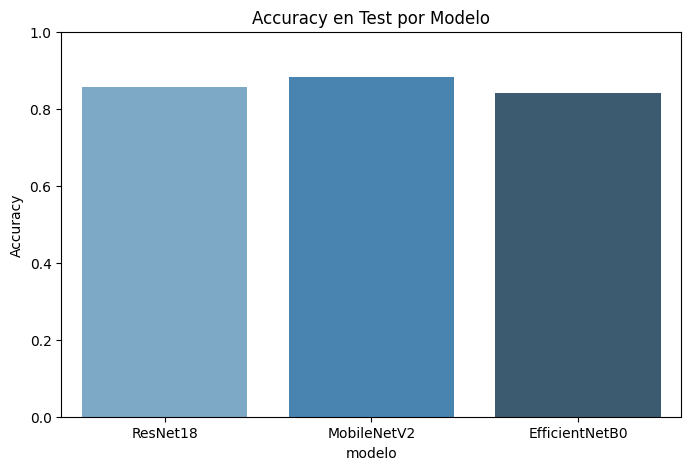

/tmp/ipython-input-1036020537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="modelo", y="test_f1_macro", palette="Greens_d")


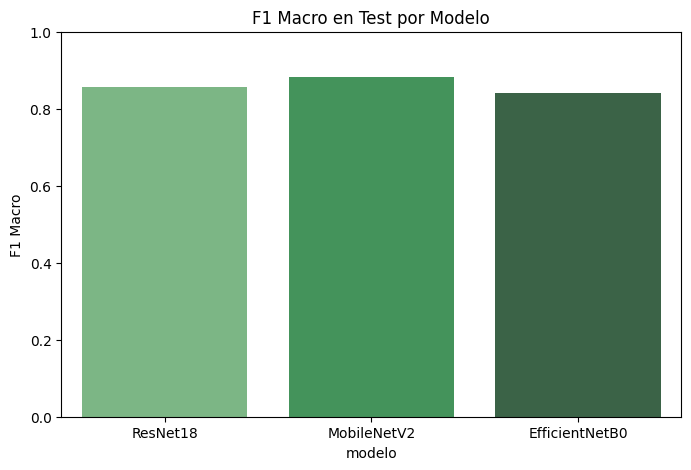

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

RESULTS_DIR.mkdir(exist_ok=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="modelo", y="test_acc", palette="Blues_d")
plt.title("Accuracy en Test por Modelo")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.savefig(RESULTS_DIR / "accuracy_por_modelo.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="modelo", y="test_f1_macro", palette="Greens_d")
plt.title("F1 Macro en Test por Modelo")
plt.ylabel("F1 Macro")
plt.ylim(0, 1)
plt.savefig(RESULTS_DIR / "f1macro_por_modelo.png", dpi=150, bbox_inches="tight")
plt.show()


## 6. Inferencia de ejemplo

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mostrando inferencias con el modelo ganador: MobileNetV2



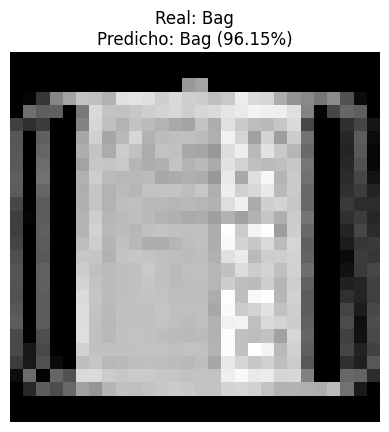

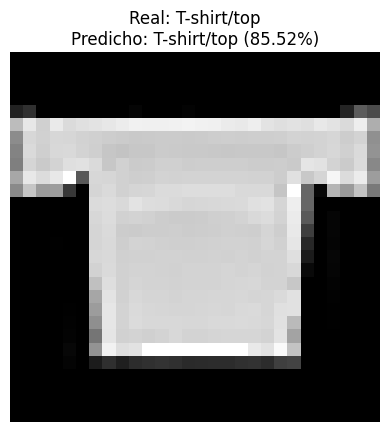

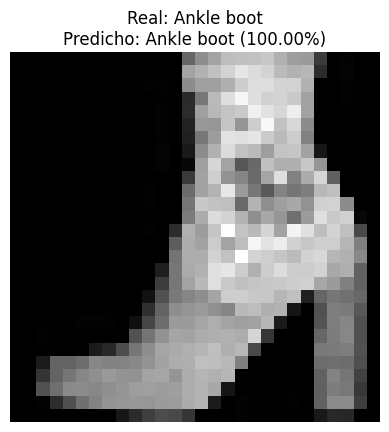

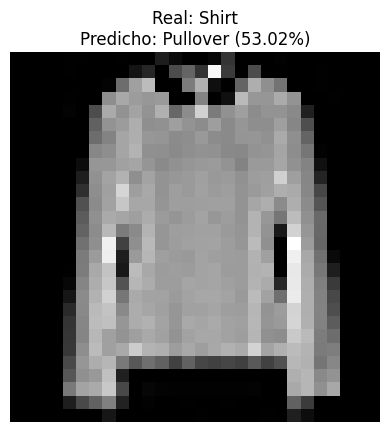

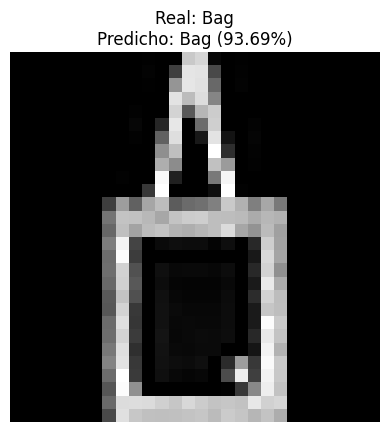

In [11]:
# Asegúrate de que estas variables estén definidas antes
NUM_CLASSES = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reconstruir el modelo ganador y cargar pesos
best_model_name = "MobileNetV2"
model = MODELS[best_model_name](NUM_CLASSES).to(device)
model.load_state_dict(torch.load(RESULTS_DIR / f"{best_model_name}_best.pth", map_location=device))
model.eval()

# Mostrar algunas inferencias en test
import random
from torchvision.utils import make_grid
from PIL import Image

inv_transform = transforms.Normalize(mean=[-1], std=[1/0.5])  # inverso de Normalize((0.5,), (0.5,))
examples = random.sample(range(len(test_dataset)), 5)

print(f"Mostrando inferencias con el modelo ganador: {best_model_name}\n")

for idx in examples:
    img, label = test_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).cpu().detach().numpy().flatten()
    pred_class = np.argmax(probs)
    confidence = probs[pred_class]

    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Real: {class_names[label]}\nPredicho: {class_names[pred_class]} ({confidence:.2%})")
    plt.axis("off")
    plt.show()


## 7. Guardado de resultados

In [12]:
import os
from shutil import copyfile

print("Archivos generados en /fashion_results:")
for file in sorted(os.listdir(RESULTS_DIR)):
    print("-", file)

drive_path = "/content/drive/MyDrive/FashionMNIST_Results"
os.makedirs(drive_path, exist_ok=True)

for file in RESULTS_DIR.iterdir():
    copyfile(file, os.path.join(drive_path, file.name))

print(f"Resultados copiados a {drive_path}")



Archivos generados en /fashion_results:
- EfficientNetB0_best.pth
- MobileNetV2_best.pth
- ResNet18_best.pth
- accuracy_por_modelo.png
- f1macro_por_modelo.png
- tabla_comparativa.csv
Resultados copiados a /content/drive/MyDrive/FashionMNIST_Results
